https://towardsdatascience.com/basic-curve-fitting-of-scientific-data-with-python-9592244a2509

### тут же ищем параметры для power law

находим параметры повер лау для шагов разной длительности. также смотрим, как отличаются параметры возле стен, в углах, в центре поля

In [2]:
import statistics
from scipy.optimize import curve_fit
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [3]:
def power_law(x, a, b):
    return a*np.power(x, b)

In [4]:
def build3ShistLog(df,n):
    #sampRate = len(df) / (df.iloc[-1]['time'] - df.iloc[0]['time'])
    #step = round(sampRate * n)
    #chose which samples will remain
    df = df.dropna()
    df = df.reset_index()
    df = df.drop(['index'], axis=1)

    # TODO: is it resampling??? if yes - remove 
    time_last = df['time'][0]
    ind_good = [0]
    for i in range(1, len(df)):
        if df['time'][i] - time_last >= n:
            time_last = df['time'][i]
            ind_good.append(i)    
    df = df.iloc[ind_good]
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    
    #k = []
    #if step == 0:
        #step = 1
    #for i in range(len(df)):
        #if i % step == 0:
            #k.append(i)
    #df = df.iloc[k]
    
    xy = []
    x0 = df['x'][0]
    y0 = df['y'][0]
    #delX = []
    #delY = []
    for i in range(len(df)):
        # TODO: why this formula?
        
        dx = df.iloc[i]['x'] - x0
        dy = df.iloc[i]['y'] - y0
        xxy = pow(pow(dx, 2) + pow(dy, 2), 0.5)
        #delX.append(dx)
        #delY.append(dy)
        xy.append(xxy)
        x0 = df.iloc[i]['x']
        y0 = df.iloc[i]['y']

    df.insert(3, "xy", xy)

    xynum = df['xy'].to_numpy()
    #histogram
    plt.figure()
    plt.yscale("log")
    kk = plt.hist(xynum, bins=100)
    plt.show()
    return kk

def makeRegrNew(histOut, trn):
    x = histOut[1][1:]
    y = histOut[0]
    # Fit the dummy power-law data
    pars, cov = curve_fit(f=power_law, xdata=x, ydata=y, p0=[0, 0], bounds=(-np.inf, np.inf))
    # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    # Calculate the residuals
    res = y - power_law(x, *pars)
    print(pars)
    return pars   

### Load Trajectories (or preproc)

In [29]:
def open_preprocessed_data(fname):
    import pickle
    with open(fname, 'rb') as inp:
        sub_trajs_list = pickle.load(inp)
    return sub_trajs_list

# Open pre-processed files (or use preproc functions for raw data)
PATH = 'preprocessed_dataset/'
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']


df_dict_subtraj = {}
for tr_name in dfs_names:
    tr = open_preprocessed_data(PATH + tr_name + '.pkl')
    df_dict_subtraj[tr_name] = tr

df_dict = {}
for k, df in df_dict_subtraj.items():
    df_dict[k] = pd.concat(df)

## If raw dataset:
# 1. cut_jumps;
# 2. rescale x and y coords to fit area size 
# 3. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
# 4. resample to required dt

In [131]:
def build_log_hist(df, binn, hist_title):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx[0], dy[0] = 0., 0.

    ## Ignore gaps in recording (== 0.)
    mask = dx.index != 0
    dx = dx * 1*mask
    dy = dy * 1*mask    

    xy = (dx**2 + dy**2)**0.5
    df['xy'] = xy 

    plt.yscale("log")
    xy_np = df['xy'].to_numpy()
    kk = plt.hist(xy_np, bins=binn)
    plt.title(f'{hist_title}, samples num: {df.shape[0]}')
    plt.show()

    return kk

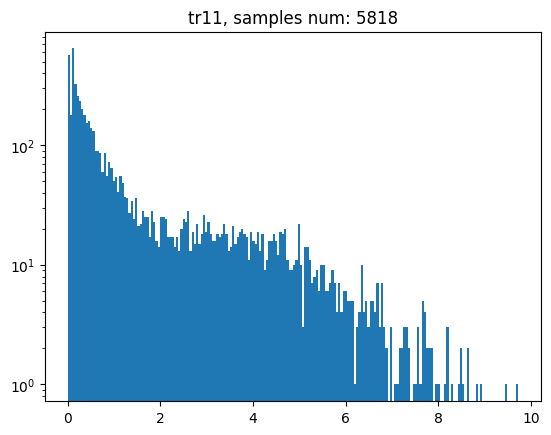

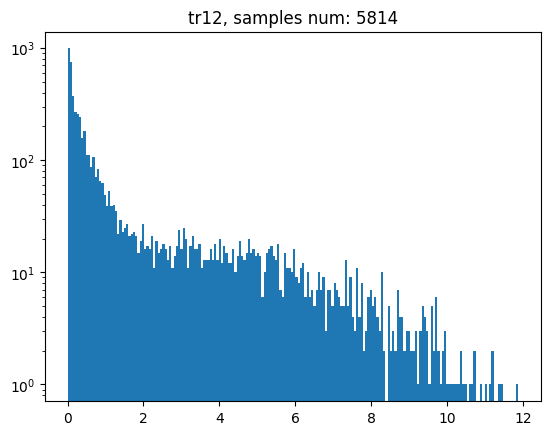

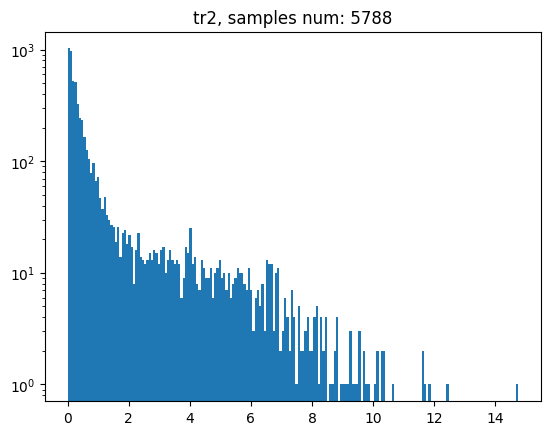

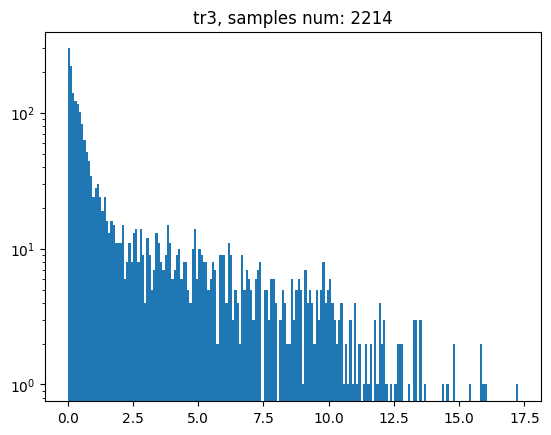

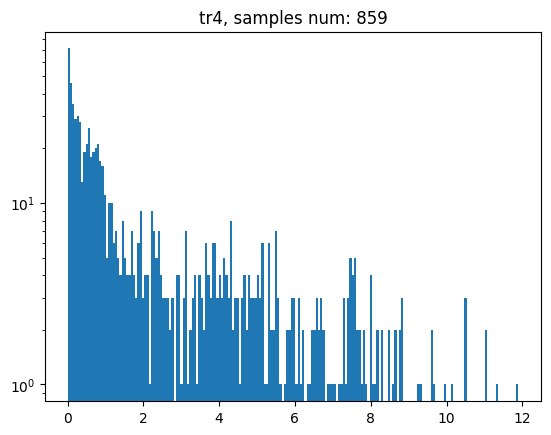

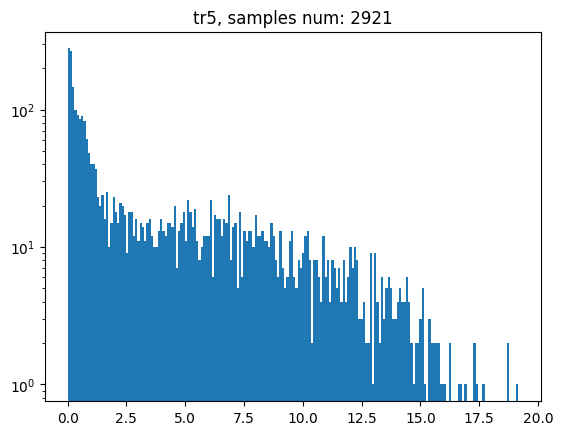

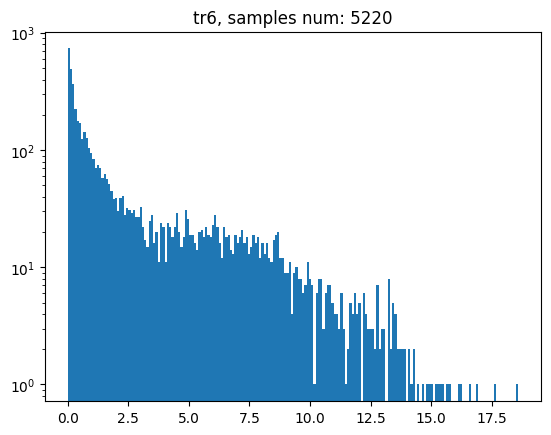

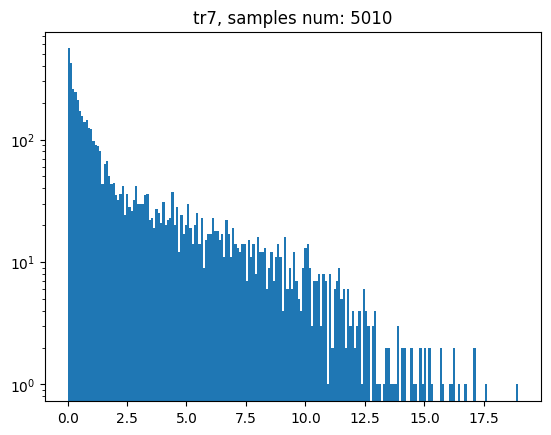

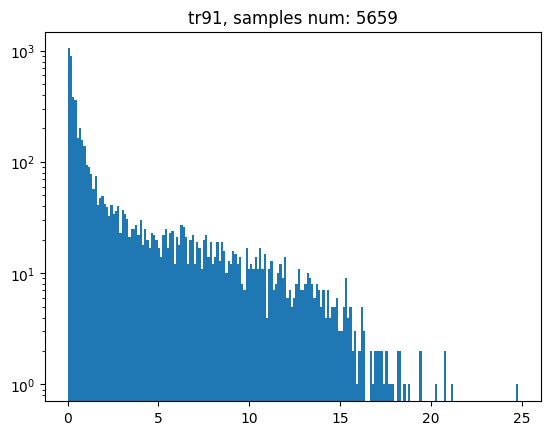

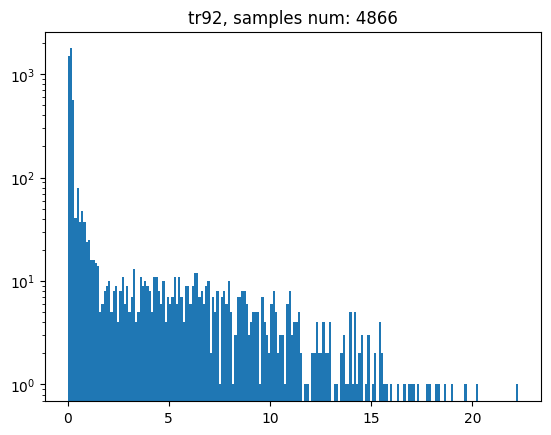

In [132]:
df_steps_hist = {}
for k, df in df_dict.items():

    h = build_log_hist(df, binn=200, hist_title=k)
    df_steps_hist[k] = h
    # TODO: what is the name of x-axis ??? len of area len units ???
    # TODO: threshold for dropping "sitting" column

In [139]:
def fit_power_law(histOut):
    x = histOut[1][1:]
    y = histOut[0]
    pars, cov = curve_fit(f=power_law, xdata=x, ydata=y,
                          p0=[1., 1.], bounds=(-np.inf, np.inf))

    # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    res = y - power_law(x, *pars)
    return pars, res, stdevs

[64.53566882 -0.76651995]
[68.93288726 -0.97437735]
[100.90016938  -0.95925115]
[38.32052024 -0.88186569]
[ 9.90767262 -0.72520701]
[48.48026229 -0.80810843]
[92.61465986 -0.90381166]
[91.57095767 -0.81408325]
[141.78563985  -1.01129838]
[126.45686442  -1.20859027]


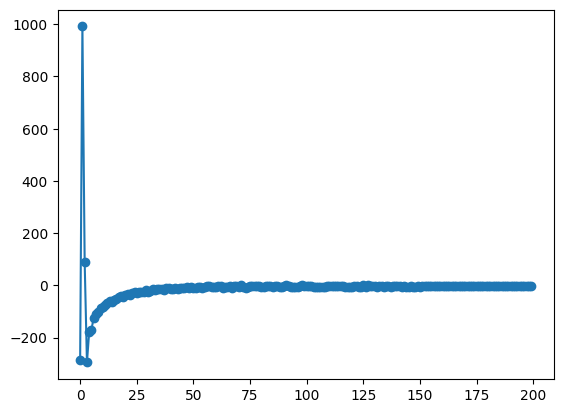

In [141]:
aas = []
bbs = []

for k, df in df_steps_hist.items():
    pars, res, stdevs = fit_power_law(df)
    print(pars)

    aas.append(pars[0])
    bbs.append(pars[1])
    # break

plt.plot(res)
plt.scatter(np.arange(0, len(res)), res)
plt.show()

In [142]:
print(statistics.mean(aas))
print(statistics.mean(bbs))

78.35053024143896
-0.9053113137558666


### повторим анализ для 0.5 с

In [ ]:
# STOPPED HERE

In [143]:
# kks = {}
# for i in range(len(dfs)):
#     # т е тут построенный гистографммы со всем колонками, но я в итоге убираю первую колонку
#     #kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])
#     kks[names[i]] = build3ShistLog(dfs[i], 0.5)
#     kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])

In [144]:
# aas = []
# bbs = []
# for i in kks:
#     otv = makeRegrNew(kks[i], i)
#     aas.append(otv[0])
#     bbs.append(otv[1])

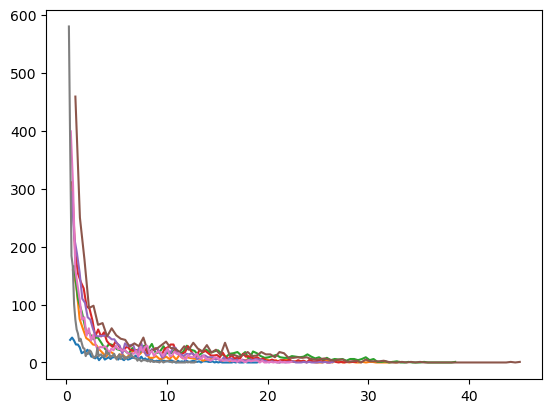

In [49]:
for i in kks:
    plt.plot(kks[i][1][1:],kks[i][0])

## проведем анализ 0.5 с центр

In [28]:
#удалим тр 92
del dfs[6]

In [30]:
del names[6]
names

['tr4', 'tr3', 'tr5', 'tr6', 'tr7', 'tr91', 'tr1', 'tr2']

In [19]:
def addNearWalls(trN):
    bord_trN = {'xmi':trN['x'].min(), 'xma': trN['x'].max(), 'ymi':trN['y'].min(), 'yma':trN['y'].max()}
    trN['near_wall'] = 0
    ylength = bord_trN['yma'] - bord_trN['ymi'] 
    xlength = bord_trN['xma'] - bord_trN['xmi'] 
    xl = bord_trN['xmi']  + xlength * 0.1
    xr = bord_trN['xma']  - xlength * 0.1
    yd = bord_trN['ymi']  + ylength * 0.1
    yu = bord_trN['yma']  - ylength * 0.1
    
    for i in range(len(trN)):     
        if trN['x'].iloc[i] < xl:
            if trN['y'].iloc[i] > yu:
                trN['near_wall'].iloc[i] = 40
            elif trN['y'].iloc[i] < yd:
                trN['near_wall'].iloc[i] = 30
            else:
                trN['near_wall'].iloc[i] = 4
        elif trN['x'].iloc[i] > xr:
            if trN['y'].iloc[i] > yu:
                trN['near_wall'].iloc[i] = 10
            elif trN['y'].iloc[i] < yd:
                trN['near_wall'].iloc[i] = 20
            else:
                trN['near_wall'].iloc[i] = 2
        elif trN['y'].iloc[i] > yu:
            trN['near_wall'].iloc[i] = 1
        elif trN['y'].iloc[i] < yd:
            trN['near_wall'].iloc[i] = 3
    print(yd, yu)
    
    return trN

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 3
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 20
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 2
C:\Use

-39.9005 20.7195


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 4
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 40
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 1
C:\Use

-37.7954 35.617399999999996


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 3
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 20
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 30
C:\Us

-39.8268 39.678799999999995


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 3
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 30
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 4
C:\Use

-33.4707 36.219699999999996


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 10
C:\Use

-24.753 32.775


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 10
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 20
C:\Us

-33.9952 33.9952


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 10
C:\Use

-37.9063 36.1313


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 10
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 2
C:\Use

-37.053399999999996 37.1834


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 10
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15136\1753321440.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trN['near_wall'].iloc[i] = 2
C:\Use

-8.364999999999998 33.235


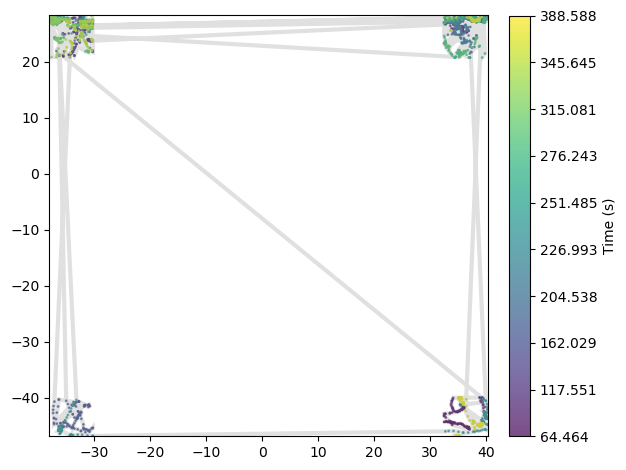

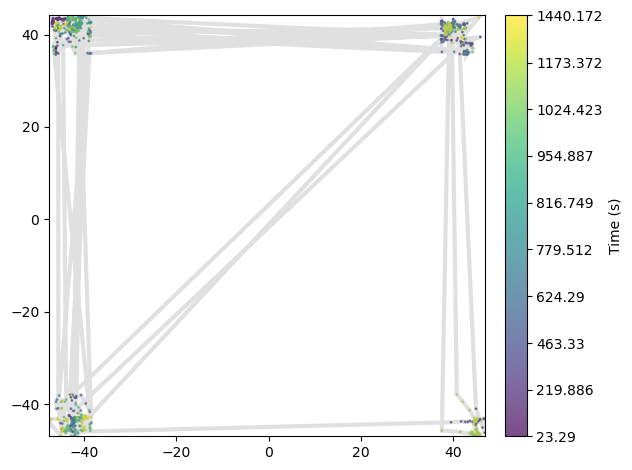

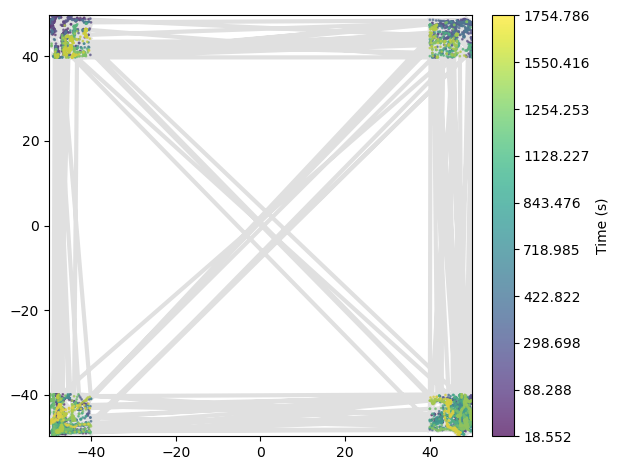

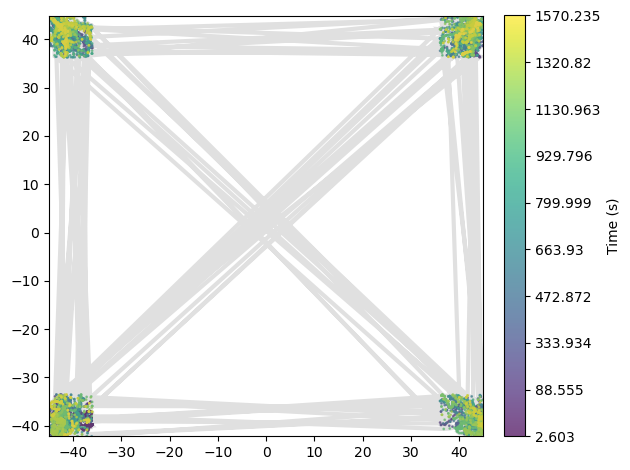

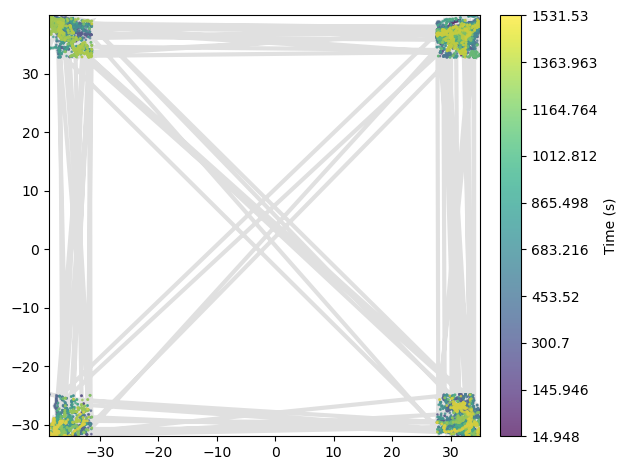

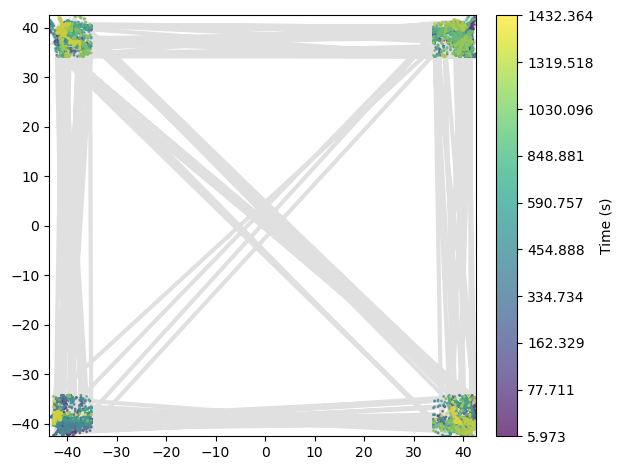

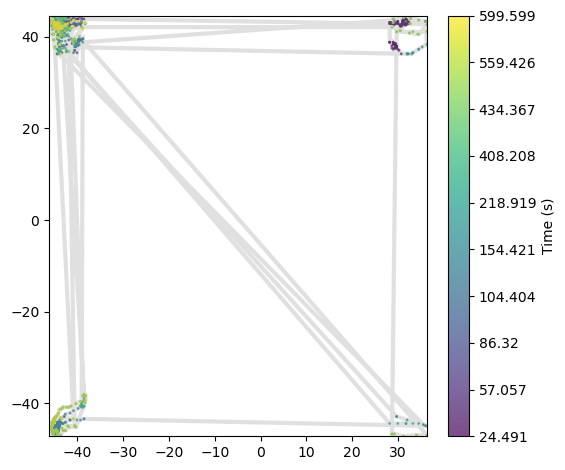

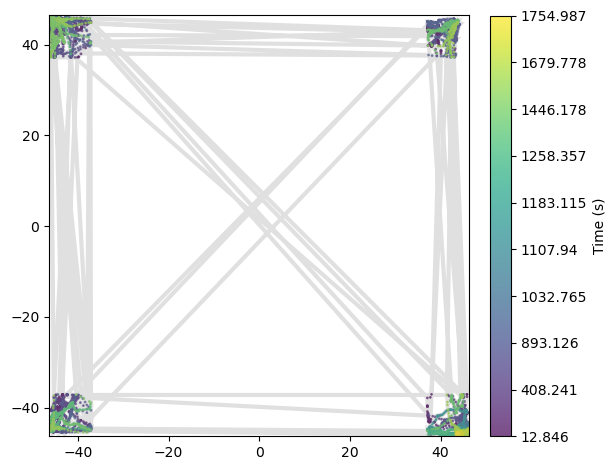

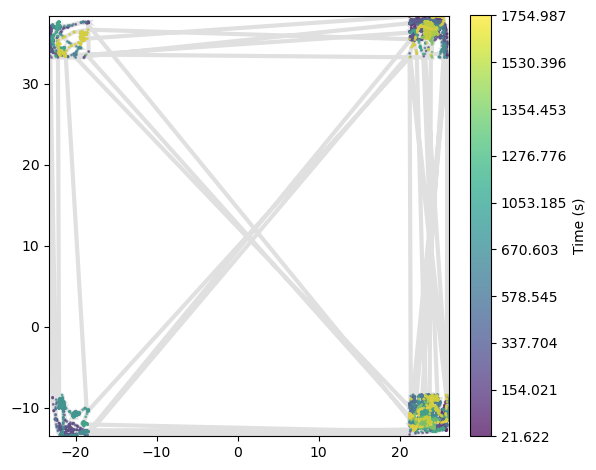

In [25]:
for i in range(len(dfs)):
    dfs[i] = addNearWalls(dfs[i])
    traja.plot(dfs[i].loc[dfs[i]['near_wall'] >= 10])

In [33]:
dfs0 = []
for i in dfs:
    df = i.loc[i['near_wall']==0]
    dfs0.append(df)

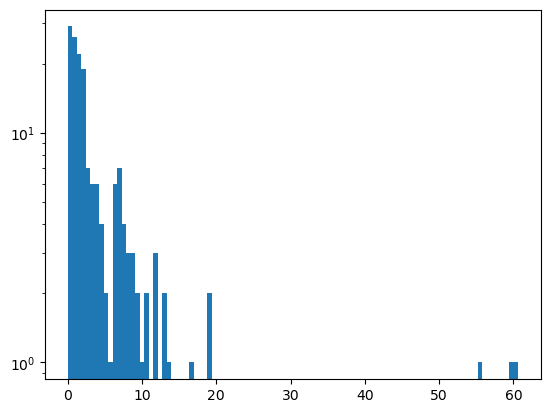

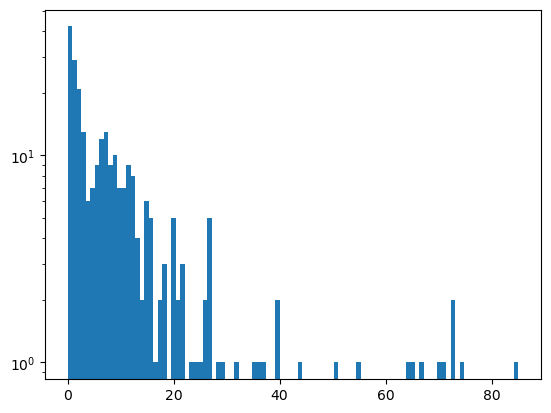

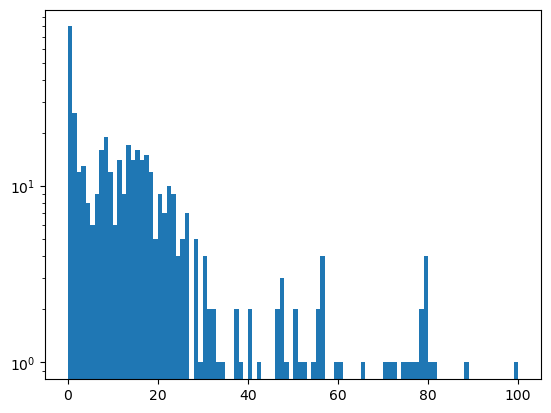

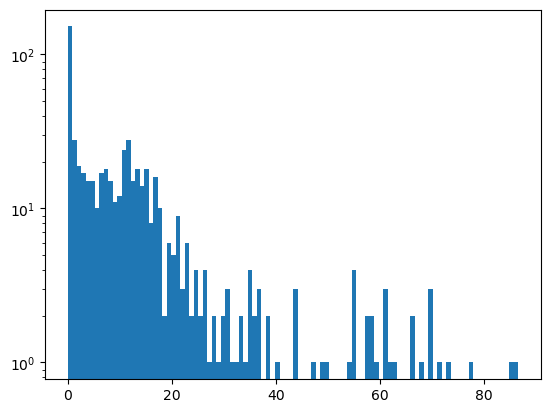

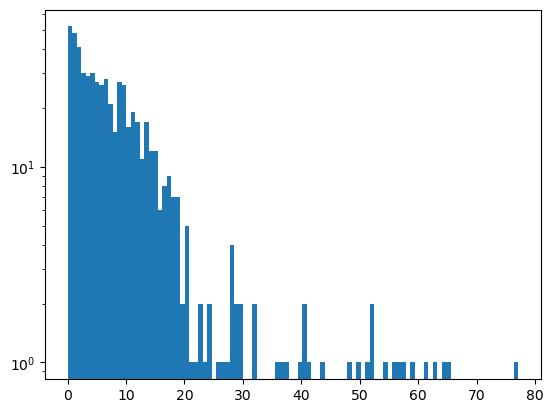

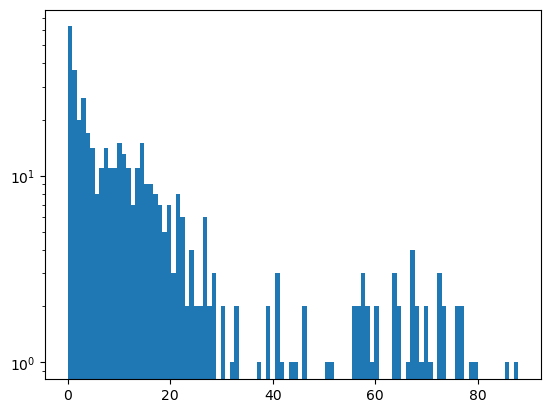

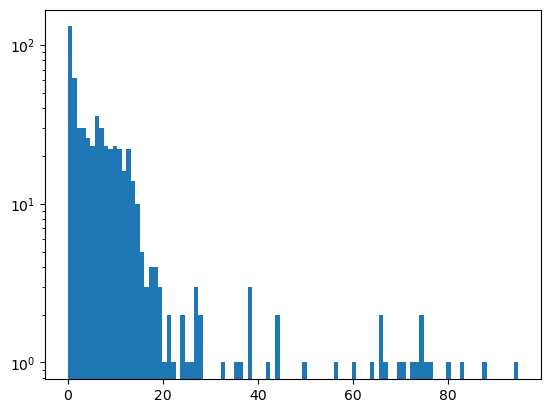

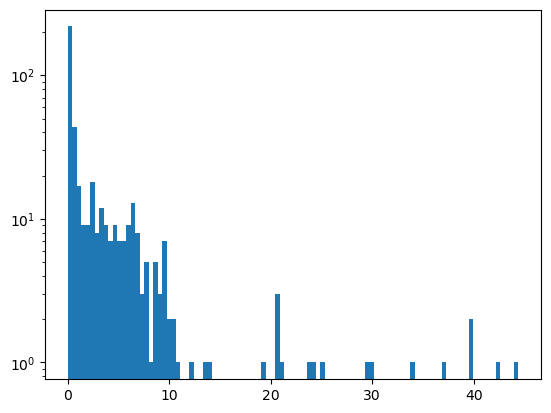

In [52]:
kks0 = {}

for i in range(len(dfs0)):
    # т е тут построенный гистографммы со всем колонками, но я в итоге убираю первую колонку
    #kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])
    kks0[names[i]] = build3ShistLog(dfs0[i], 0.5)
    kks0[names[i]] = (kks0[names[i]][0][1:],kks0[names[i]][1][1:])

In [53]:
aas0 = []
bbs0 = []
for i in kks0:
    otv0 = makeRegrNew(kks0[i], i)
    aas0.append(otv0[0])
    bbs0.append(otv0[1])

[37.79918839 -1.2695907 ]
[50.06283956 -0.99115436]
[41.57380851 -0.70003735]
[48.12435407 -0.71258308]
[85.55932865 -0.85826424]
[60.69242737 -0.8515541 ]
[119.16163815  -0.98459548]
[33.88457673 -1.14916302]


In [54]:
print(statistics.mean(aas0))
print(statistics.mean(bbs0))


59.60727018065556
-0.939617791251118


## проведем анализ 0.5 с углы

In [56]:
dfsC = []
for i in dfs:
    df = i.loc[i['near_wall']>=10]
    dfsC.append(df)

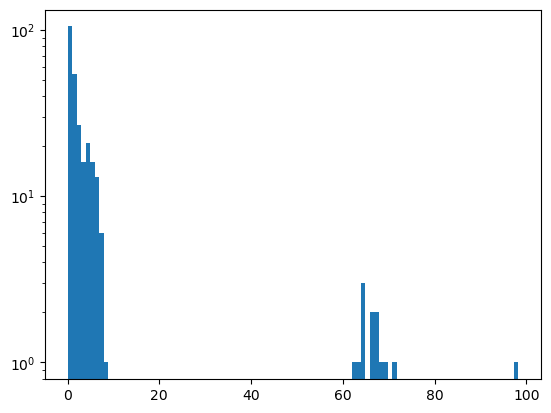

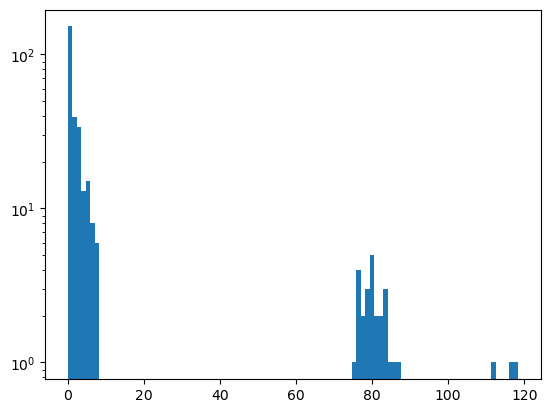

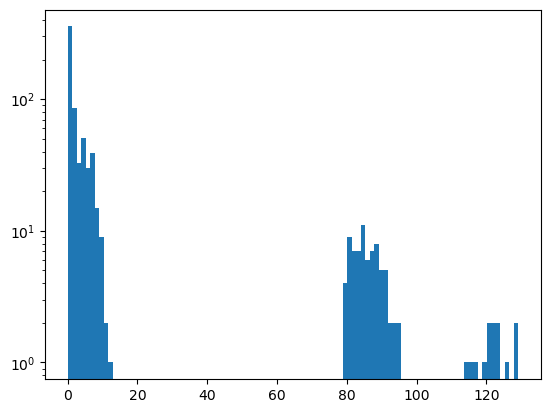

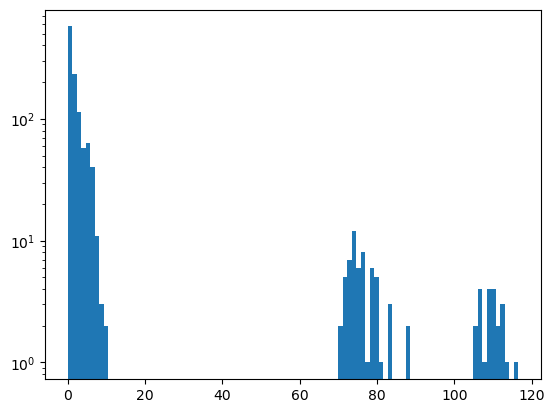

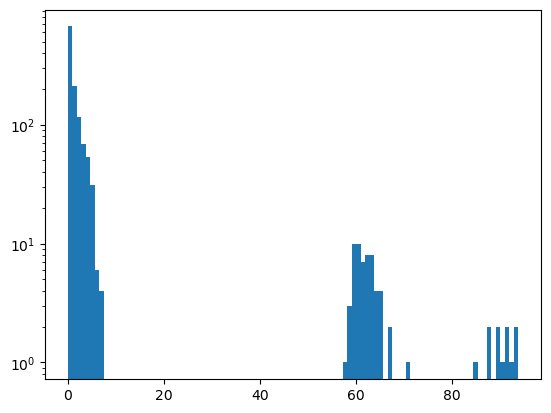

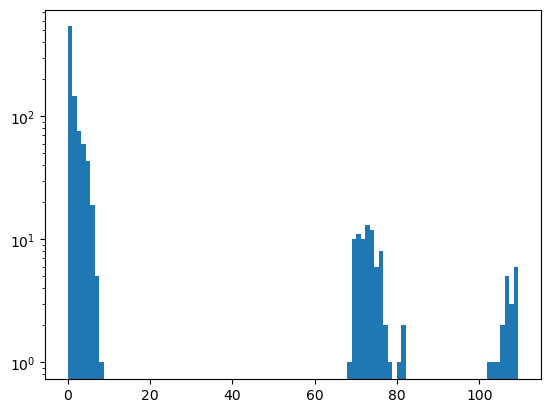

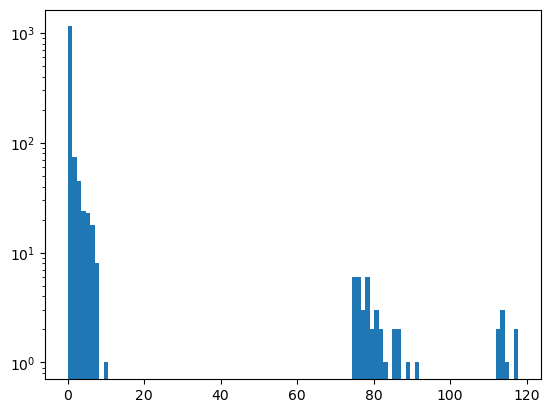

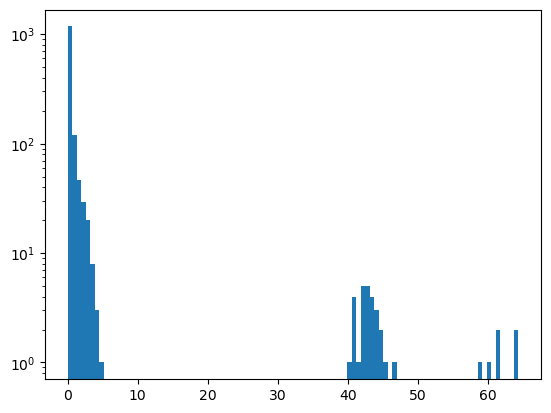

In [57]:
kksC = {}

for i in range(len(dfsC)):
    # т е тут построенный гистографммы со всем колонками, но я в итоге убираю первую колонку
    #kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])
    kksC[names[i]] = build3ShistLog(dfsC[i], 0.5)
    kksC[names[i]] = (kksC[names[i]][0][1:],kksC[names[i]][1][1:])

In [59]:
aasC = []
bbsC = []
for i in kksC:
    otvC = makeRegrNew(kksC[i], i)
    aasC.append(otvC[0])
    bbsC.append(otvC[1])

[163.6124834   -1.61927773]
[176.41625689  -1.61579687]
[351.7214247   -1.47455057]
[1238.70400192   -1.95939793]
[716.50498247  -1.89453085]
[632.0813587   -1.82595015]
[349.28610094  -1.74264186]
[214.2268993   -2.30934651]


In [60]:
print(statistics.mean(aasC))
print(statistics.mean(bbsC))


480.31918853922025
-1.805186557717673


## проведем анализ 0.5 с walls

In [63]:
dfsW = []
for i in dfs:
    df = i.loc[(i['near_wall']>=1) & (i['near_wall']<=4)]
    dfsW.append(df)

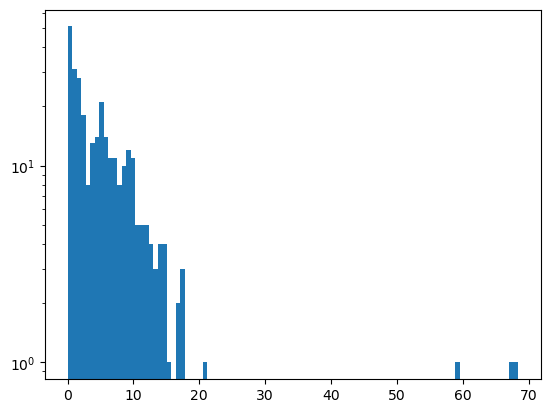

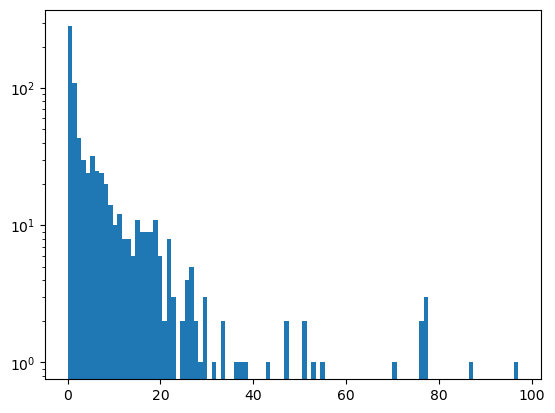

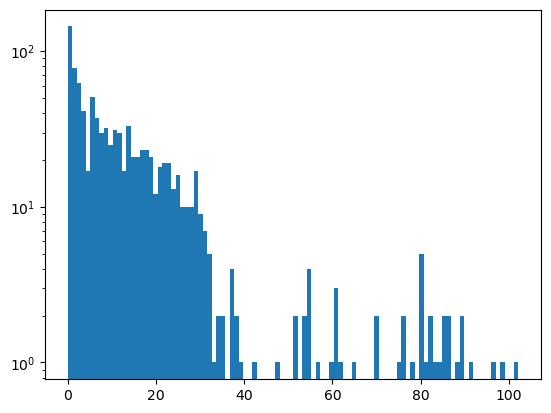

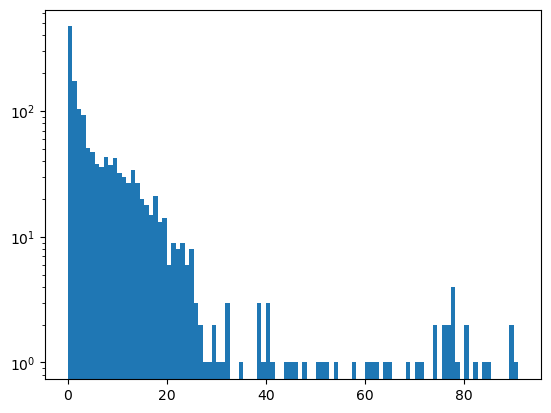

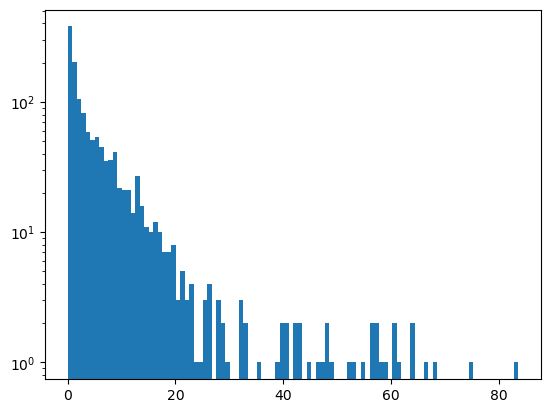

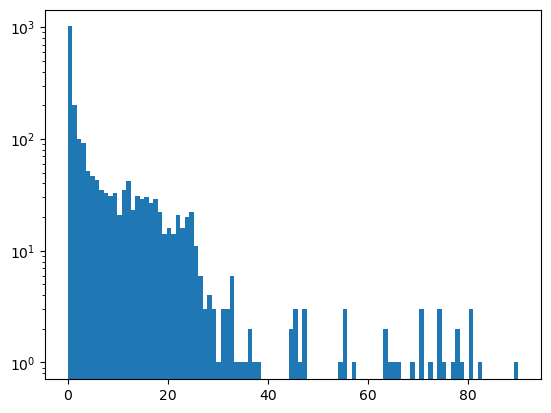

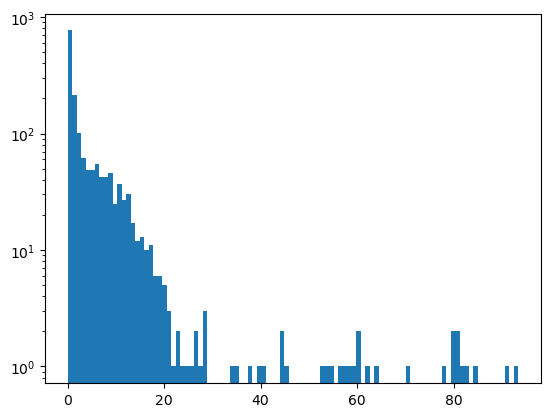

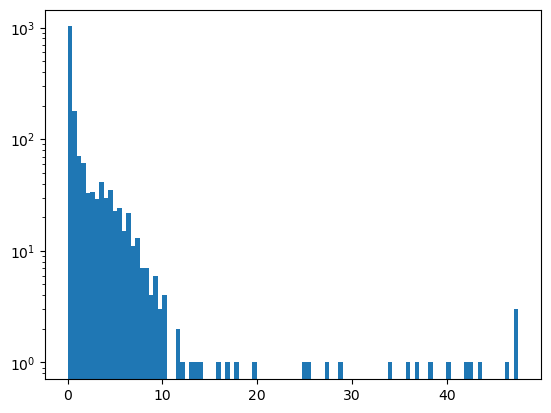

In [64]:
kksW = {}

for i in range(len(dfsW)):
    # т е тут построенный гистографммы со всем колонками, но я в итоге убираю первую колонку
    #kks[names[i]] = (kks[names[i]][0][1:],kks[names[i]][1][1:])
    kksW[names[i]] = build3ShistLog(dfsW[i], 0.5)
    kksW[names[i]] = (kksW[names[i]][0][1:],kksW[names[i]][1][1:])

In [65]:
aasW = []
bbsW = []
for i in kksW:
    otvW = makeRegrNew(kksW[i], i)
    aasW.append(otvW[0])
    bbsW.append(otvW[1])

[49.13930448 -0.9840356 ]
[245.12406558  -1.33969212]
[157.47450116  -0.85934618]
[347.3193598   -1.13745451]
[381.86257336  -1.26276418]
[373.94562427  -1.14415975]
[471.19607175  -1.33952661]
[157.88119629  -1.44396358]


In [66]:
print(statistics.mean(aasW))
print(statistics.mean(bbsW))


272.9928370856509
-1.18886781756936
